# Business Case 4 - Crypto_Forecasting

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

from math import ceil 
from datetime import datetime
# %pip install abc_analysis
from abc_analysis import abc_analysis
from mlxtend.frequent_patterns import apriori, association_rules
from tabulate import tabulate
from functools import reduce
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

In [19]:
close_price = pd.read_csv("close.csv", index_col="Date")
high = pd.read_csv("high.csv", index_col="Date")
low = pd.read_csv("low.csv", index_col="Date")
volume = pd.read_csv("volume.csv", index_col="Date")
open_price = pd.read_csv("open.csv", index_col="Date")
adj_close = pd.read_csv("adj_close.csv", index_col="Date")


In [20]:
crypto = pd.concat([open_price, close_price, high, low, volume, adj_close], axis=1, join="inner")

In [21]:
crypto

ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-04-26       NaN        NaN        NaN        NaN   1265.989990   
2017-04-27       NaN        NaN        NaN        NaN   1281.880005   
2017-04-28       NaN        NaN        NaN        NaN   1317.739990   
2017-04-29       NaN        NaN        NaN        NaN   1317.839966   
2017-04-30       NaN        NaN        NaN        NaN   1321.869995   
...              ...        ...        ...        ...           ...   
2022-04-21  0.937272  24.290905  78.268646  46.146866  41371.515625   
2022-04-22  0.910335  23.305815  75.084648  45.084476  40525.863281   
2022-04-23  0.907185  23.089521  74.127480  45.955498  39738.722656   
2022-04-24  0.888279  23.259838  72.892731  45.171925  39478.375000   
2022-04-25  0.886378  22.330229  71.606567  44.373047  39472.605469   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD     SOL-USD  ...  \
Date                                                                  ...   
2017-04-26          NaN        NaN        NaN        NaN         NaN  ...   
2017-04-27          NaN        NaN        NaN        NaN         NaN  ...   
2017-04-28          NaN        NaN        NaN        NaN         NaN  ...   
2017-04-29          NaN        NaN        NaN        NaN         NaN  ...   
2017-04-30          NaN        NaN        NaN        NaN         NaN  ...   
...                 ...        ...        ...        ...         ...  ...   
2022-04-21  3077.829346  14.022598  94.938416   1.417712  105.497673  ...   
2022-04-22  2986.938721  13.587431  90.784470   1.379697  101.757423  ...   
2022-04-23  2964.802246  13.609134  93.669579   1.399106  100.619781  ...   
2022-04-24  2937.347168  13.341961  89.436935   1.365753  100.727188  ...   
2022-04-25  2922.990234  13.287835  90.470451   1.344233   99.241409  ...   

             ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-04-26       NaN        NaN        NaN        NaN   1281.079956   
2017-04-27       NaN        NaN        NaN        NaN   1317.729980   
2017-04-28       NaN        NaN        NaN        NaN   1316.479980   
2017-04-29       NaN        NaN        NaN        NaN   1321.790039   
2017-04-30       NaN        NaN        NaN        NaN   1347.890015   
...              ...        ...        ...        ...           ...   
2022-04-21  0.910474  23.305845  75.080742  45.097389  40527.363281   
2022-04-22  0.907154  23.089931  74.122963  45.963348  39740.320312   
2022-04-23  0.888503  23.271534  72.920013  45.180782  39486.730469   
2022-04-24  0.886350  22.330360  71.603035  44.369541  39469.292969   
2022-04-25  0.898695  22.133928  72.867424  42.973213  40458.308594   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD     SOL-USD  
Date                                                                  
2017-04-26          NaN        NaN        NaN        NaN         NaN  
2017-04-27          NaN        NaN        NaN        NaN         NaN  
2017-04-28          NaN        NaN        NaN        NaN         NaN  
2017-04-29          NaN        NaN        NaN        NaN         NaN  
2017-04-30          NaN        NaN        NaN        NaN         NaN  
...                 ...        ...        ...        ...         ...  
2022-04-21  2987.480713  13.588746  90.799156   1.379862  101.776138  
2022-04-22  2964.835693  13.609354  93.682289   1.399139  100.612053  
2022-04-23  2938.114014  13.343726  89.534752   1.365971  100.744438  
2022-04-24  2922.732666  13.287423  90.560234   1.344245   99.235794  
2022-04-25  3009.393555  13.458693  97.035728   1.352666  101.247635  

[1826 rows x 60 columns]

In [22]:
ada_usd = crypto["ADA-USD"]
atom_usd = crypto["ATOM-USD"]
avax_usd = crypto["AVAX-USD"]
axs_usd = crypto["AXS-USD"]
btc_usd = crypto["BTC-USD"]
eth_usd = crypto["ETH-USD"]
luna_usd = crypto["LUNA1-USD"]
matic_usd = crypto["MATIC-USD"]
sol_usd = crypto["SOL-USD"]
link_usd= crypto["LINK-USD"]

In [23]:
all_pairs = ['ADA-USD', 'ATOM-USD', 'AVAX-USD', 'AXS-USD', 'LUNA-USD', 'MATIC-USD', 'BTC-USD', 'ETH-USD', 'SOL-USD', "LINK-USD"]
close_price["LUNA-USD"] = close_price["LUNA1-USD"]
close_price.drop("LUNA1-USD", axis=1, inplace=True)


In [24]:
ada_usd.columns.values[0] = "Open Price"
ada_usd.columns.values[1] = "Close Price"
ada_usd.columns.values[2] = "Daily High"
ada_usd.columns.values[3] = "Daily Low"
ada_usd.columns.values[4] = "Volume"
ada_usd.columns.values[5] = "Adj Close"

atom_usd.columns.values[0] = "Open Price"
atom_usd.columns.values[1] = "Close Price"
atom_usd.columns.values[2] = "Daily High"
atom_usd.columns.values[3] = "Daily Low"
atom_usd.columns.values[4] = "Volume"
atom_usd.columns.values[5] = "Adj Close"

avax_usd.columns.values[0] = "Open Price"
avax_usd.columns.values[1] = "Close Price"
avax_usd.columns.values[2] = "Daily High"
avax_usd.columns.values[3] = "Daily Low"
avax_usd.columns.values[4] = "Volume"
avax_usd.columns.values[5] = "Adj Close"

axs_usd.columns.values[0] = "Open Price"
axs_usd.columns.values[1] = "Close Price"
axs_usd.columns.values[2] = "Daily High"
axs_usd.columns.values[3] = "Daily Low"
axs_usd.columns.values[4] = "Volume"
axs_usd.columns.values[5] = "Adj Close"

btc_usd.columns.values[0] = "Open Price"
btc_usd.columns.values[1] = "Close Price"
btc_usd.columns.values[2] = "Daily High"
btc_usd.columns.values[3] = "Daily Low"
btc_usd.columns.values[4] = "Volume"
btc_usd.columns.values[5] = "Adj Close"

eth_usd.columns.values[0] = "Open Price"
eth_usd.columns.values[1] = "Close Price"
eth_usd.columns.values[2] = "Daily High"
eth_usd.columns.values[3] = "Daily Low"
eth_usd.columns.values[4] = "Volume"
eth_usd.columns.values[5] = "Adj Close"

luna_usd.columns.values[0] = "Open Price"
luna_usd.columns.values[1] = "Close Price"
luna_usd.columns.values[2] = "Daily High"
luna_usd.columns.values[3] = "Daily Low"
luna_usd.columns.values[4] = "Volume"
luna_usd.columns.values[5] = "Adj Close"

link_usd.columns.values[0] = "Open Price"
link_usd.columns.values[1] = "Close Price"
link_usd.columns.values[2] = "Daily High"
link_usd.columns.values[3] = "Daily Low"
link_usd.columns.values[4] = "Volume"
link_usd.columns.values[5] = "Adj Close"

matic_usd.columns.values[0] = "Open Price"
matic_usd.columns.values[1] = "Close Price"
matic_usd.columns.values[2] = "Daily High"
matic_usd.columns.values[3] = "Daily Low"
matic_usd.columns.values[4] = "Volume"
matic_usd.columns.values[5] = "Adj Close"

sol_usd.columns.values[0] = "Open Price"
sol_usd.columns.values[1] = "Close Price"
sol_usd.columns.values[2] = "Daily High"
sol_usd.columns.values[3] = "Daily Low"
sol_usd.columns.values[4] = "Volume"
sol_usd.columns.values[5] = "Adj Close"

In [25]:
btc_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\btc_usd.xlsx",sheet_name='btc_usd', index = True)

eth_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\eth_usd.xlsx",sheet_name='eth_usd', index = True)

ada_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\ada_usd.xlsx",sheet_name='ada_usd', index = True)

atom_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\atom_usd.xlsx",sheet_name='atom_usd', index = True)

avax_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\avax_usd.xlsx",sheet_name='avax_usd', index = True)

axs_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\axs_usd.xlsx",sheet_name='axs_usd', index = True)

luna_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\luna_usd.xlsx",sheet_name='luna_usd', index = True)

matic_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\matic_usd.xlsx",sheet_name='matic_usd', index = True)

sol_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\sol_usd.xlsx",sheet_name='sol_usd', index = True)

link_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\link_usd.xlsx",sheet_name='link_usd', index = True)

In [26]:
# IMPORTANT NOTE: We can adapt this similar plot for each type of currency 

import plotly.graph_objects as go
import pandas as pd

df = pd.read_excel("btc_usd.xlsx", sheet_name="btc_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for BTC-USD',
    xaxis_title = 'Date',
    yaxis_title = f'BTC-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [27]:
df = pd.read_excel("eth_usd.xlsx", sheet_name="eth_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ETH-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ETH-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [30]:
df = pd.read_excel("ada_usd.xlsx", sheet_name="ada_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ADA-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ADA-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [31]:
df = pd.read_excel("atom_usd.xlsx", sheet_name="atom_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ATOM-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ATOM-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [32]:
df = pd.read_excel("avax_usd.xlsx", sheet_name="avax_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for AVAX-USD',
    xaxis_title = 'Date',
    yaxis_title = f'AVAX-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [33]:
df = pd.read_excel("axs_usd.xlsx", sheet_name="axs_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for AXS-USD',
    xaxis_title = 'Date',
    yaxis_title = f'AXS-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [34]:
df = pd.read_excel("luna_usd.xlsx", sheet_name="luna_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for LUNA-USD',
    xaxis_title = 'Date',
    yaxis_title = f'LUNA-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [35]:
df = pd.read_excel("matic_usd.xlsx", sheet_name="matic_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for MATIC-USD',
    xaxis_title = 'Date',
    yaxis_title = f'MATIC-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [36]:
df = pd.read_excel("sol_usd.xlsx", sheet_name="sol_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for SOL-USD',
    xaxis_title = 'Date',
    yaxis_title = f'SOL-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [37]:
df = pd.read_excel("link_usd.xlsx", sheet_name="link_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for LINK-USD',
    xaxis_title = 'Date',
    yaxis_title = f'LINK-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [28]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.show()
    

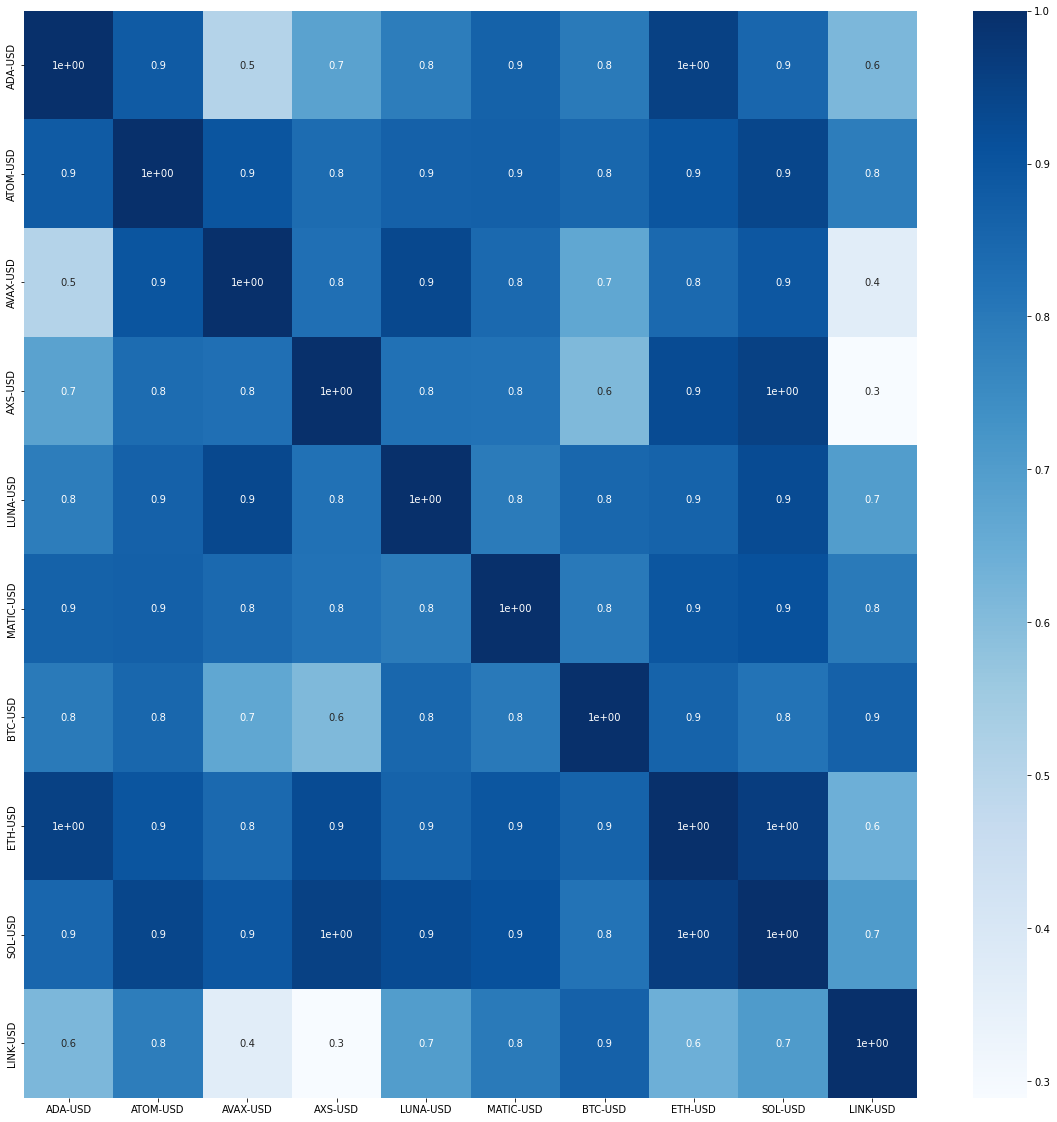

In [29]:
cor_heatmap(np.round(close_price[all_pairs].corr(method = "spearman"),3)) #######I AM NOT SURE WHICH TO USE PEARSON OR SPEARMAN (HAD LESS DIVERGENCE OF VALUES WITH PEARSON)

In [16]:
fig = go.Figure(
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
))


    # Scatter
for idx, name in enumerate(close_price):
    fig = fig.add_trace(
        go.Scatter(
            x = close_price.index,
            y = close_price[name],
            name = name,
        )
    )
fig.update_layout(
    title = 'The Correlation between Different Cryptocurrencies',
    xaxis_title = 'Date',
    yaxis_title = f'Price',
    legend_title = 'Cryptocurrencies'
)
fig.update_yaxes(type='log', tickprefix='$')
fig.show()